# Natural Language Processing Exercise

In this NLP project you will be attempting to classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews. 

We will use the [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.

In [1]:
import nltk

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('yelp.csv')

In [4]:
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


# EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.3+ KB


In [24]:
df_use = df[['stars','text','type','cool','useful','funny']]

In [25]:
df_use.head()

,stars,text,type,cool,useful,funny
0,5,My wife took me here on my birthday for breakf...,review,2,5,0
1,5,I have no idea why some people give bad review...,review,0,0,0
2,4,love the gyro plate. Rice is so good and I als...,review,0,1,0
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,1,2,0
4,5,General Manager Scott Petello is a good egg!!!...,review,0,0,0


In [26]:
df_use.groupby('stars').apply(len)

stars
1     749
2     927
3    1461
4    3526
5    3337
dtype: int64

In [27]:
df_use.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


In [28]:
df_use['text_length'] = df['text'].apply(len)

/Users/phatarasutarasuwan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
df_use.head()

,stars,text,type,cool,useful,funny,text_length
0,5,My wife took me here on my birthday for breakf...,review,2,5,0,889
1,5,I have no idea why some people give bad review...,review,0,0,0,1345
2,4,love the gyro plate. Rice is so good and I als...,review,0,1,0,76
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,1,2,0,419
4,5,General Manager Scott Petello is a good egg!!!...,review,0,0,0,469


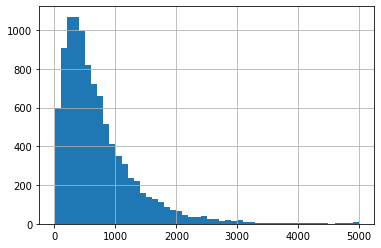

In [30]:
df['text_length'].hist(bins = 50)

# Text Pre-Processing

In [31]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

In [32]:
def process_text(msg):
    text = msg.translate(str.maketrans('', '', string.punctuation)).lower()
    stop_words = set(stopwords.words('english'))
    word_tokens = text.split()
    return [w for w in word_tokens if not w in stop_words]
    

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer=process_text).fit(df_use['text'])

In [35]:
len(bow_transformer.vocabulary_)

36271

In [37]:
msg_bow = bow_transformer.transform(df_use['text'])

In [46]:
print(msg_bow[:5])

  (0, 409)	1
  (0, 1267)	1
  (0, 1268)	1
  (0, 2046)	2
  (0, 2357)	1
  (0, 2661)	1
  (0, 3185)	1
  (0, 3949)	2
  (0, 3977)	1
  (0, 4148)	1
  (0, 4295)	1
  (0, 4353)	1
  (0, 4795)	1
  (0, 4820)	1
  (0, 5593)	1
  (0, 5680)	1
  (0, 7494)	1
  (0, 9254)	1
  (0, 10727)	1
  (0, 10917)	1
  (0, 11522)	2
  (0, 11549)	1
  (0, 11613)	3
  (0, 12153)	1
  (0, 12394)	1
  :	:
  (4, 16296)	1
  (4, 16437)	1
  (4, 16647)	1
  (4, 17178)	1
  (4, 18621)	1
  (4, 18696)	1
  (4, 18745)	1
  (4, 19555)	1
  (4, 20667)	1
  (4, 23898)	1
  (4, 25873)	1
  (4, 26139)	1
  (4, 26688)	1
  (4, 27762)	1
  (4, 27866)	1
  (4, 28044)	3
  (4, 29989)	1
  (4, 30369)	1
  (4, 30513)	1
  (4, 31313)	1
  (4, 32192)	1
  (4, 32932)	1
  (4, 33168)	1
  (4, 34766)	1
  (4, 36090)	1


In [52]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(msg_bow)

In [59]:
text_tfidf = tfidf_transformer.transform(msg_bow)
print(text_tfidf[:1])

  (0, 35411)	0.10254341330234679
  (0, 35338)	0.09984062277710568
  (0, 35026)	0.126290017309762
  (0, 34739)	0.09710007444519823
  (0, 34713)	0.07505040071026234
  (0, 34321)	0.13288905407446766
  (0, 34122)	0.09131941457674941
  (0, 33298)	0.14752909386586033
  (0, 32827)	0.08210052343400678
  (0, 32693)	0.11809752629453185
  (0, 31831)	0.07942283835005332
  (0, 31292)	0.07237245396275474
  (0, 29213)	0.15615618296462333
  (0, 29150)	0.10323052601193045
  (0, 29071)	0.1133441309807466
  (0, 28343)	0.21006296647586725
  (0, 28070)	0.15816408597035964
  (0, 27774)	0.1022911624048871
  (0, 25660)	0.20842330514096302
  (0, 25026)	0.13012651224461277
  (0, 24430)	0.13691320320200512
  (0, 24289)	0.040712054063057744
  (0, 24091)	0.11099107147497171
  (0, 23938)	0.13574097836496996
  (0, 23788)	0.08633331052669921
  :	:
  (0, 12394)	0.1641661289714964
  (0, 12153)	0.14286514013556936
  (0, 11613)	0.2501277089799737
  (0, 11549)	0.07468836339775611
  (0, 11522)	0.14805609845131878
  (0, 109

# Traning Model

In [75]:
from sklearn.naive_bayes import MultinomialNB
star_classifier = MultinomialNB().fit(text_tfidf, df_use['stars'])

In [84]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
train_test_split(df_use['text'], df_use['stars'], test_size=0.2, random_state = 101)

print(len(X_train), len(X_test), len(y_train) + len(y_test))

8000 2000 10000


# Creating a Data Pipeline

In [85]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process_text)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [86]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function process_text at 0x1a1b0e4c80>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [87]:
y_predict = pipeline.predict(X_test)

In [89]:
from sklearn.metrics import classification_report
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.89      0.39      0.54      1647
           5       0.36      0.67      0.46       353

    accuracy                           0.44      2000
   macro avg       0.25      0.21      0.20      2000
weighted avg       0.80      0.44      0.53      2000



# Decistion Tree

In [94]:
from sklearn.tree import DecisionTreeClassifier

In [95]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process_text)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', DecisionTreeClassifier()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [96]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function process_text at 0x1a1b0e4c80>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=None, max_features=None,
                                        max_leaf_node

In [97]:
y_predict = pipeline.predict(X_test)
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

           1       0.32      0.33      0.33       142
           2       0.17      0.16      0.17       194
           3       0.20      0.26      0.23       238
           4       0.38      0.40      0.39       681
           5       0.52      0.46      0.49       745

    accuracy                           0.38      2000
   macro avg       0.32      0.32      0.32      2000
weighted avg       0.39      0.38      0.38      2000



# Logistic Regression

In [98]:
from sklearn.linear_model import LogisticRegression

In [99]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process_text)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [100]:
pipeline.fit(X_train, y_train)
y_predict = pipeline.predict(X_test)

/Users/phatarasutarasuwan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/phatarasutarasuwan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [101]:
from sklearn.metrics import classification_report
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

           1       0.36      0.68      0.47        77
           2       0.16      0.55      0.25        53
           3       0.19      0.47      0.28       126
           4       0.67      0.49      0.57       966
           5       0.69      0.58      0.63       778

    accuracy                           0.53      2000
   macro avg       0.41      0.55      0.44      2000
weighted avg       0.62      0.53      0.56      2000



# RandomForest

In [102]:
from sklearn.ensemble import RandomForestClassifier

In [109]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process_text)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [110]:
pipeline.fit(X_train, y_train)

/Users/phatarasutarasuwan/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function process_text at 0x1a1b0e4c80>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                              

In [111]:
y_predict = pipeline.predict(X_test)

In [112]:
from sklearn.metrics import classification_report
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

           1       0.19      0.39      0.26        72
           2       0.10      0.29      0.14        59
           3       0.14      0.25      0.18       164
           4       0.61      0.42      0.50      1033
           5       0.53      0.52      0.53       672

    accuracy                           0.43      2000
   macro avg       0.31      0.37      0.32      2000
weighted avg       0.51      0.43      0.46      2000



# XGboosting

In [118]:
from xgboost import XGBClassifier

In [120]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process_text)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', XGBClassifier()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [121]:
pipeline.fit(X_train, y_train)
y_predict = pipeline.predict(X_test)

In [122]:
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

           1       0.30      0.68      0.42        65
           2       0.07      0.35      0.12        37
           3       0.18      0.58      0.28        96
           4       0.60      0.43      0.50       990
           5       0.63      0.51      0.57       812

    accuracy                           0.48      2000
   macro avg       0.36      0.51      0.38      2000
weighted avg       0.57      0.48      0.51      2000



## สรุป ผลของ Logistic Regression ดีที่สุดครับ